# Capstone 2.1: Predicted Circular Dichroism Spectra from Primary Amino Acid Sequence

## Data download and cleaning

Data is coming from the Protein Circular Dichroism Data Bank (https://pcddb.cryst.bbk.ac.uk/).
Citation information: The PCDDB (protein circular dichroism data bank): A bioinformatics resource for protein characterisations and methods development. Ramalli SG, Miles AJ, Janes RW, Wallace BA., J Mol Biol (2022) 

In [1]:
# Packages
import requests, io, re
from zipfile import ZipFile
import pandas as pd
import seaborn as sns

In [2]:
data_url = "https://pcddb.cryst.bbk.ac.uk/public/downloads/pcddb_pcd_and_gen.zip"

r = requests.get(data_url, stream = True) #stream=True iterates through the data one chunk at a time
z = ZipFile(io.BytesIO(r.content))

The code above connects to the database and generates a ZipFile object of all the files in the database. Let's explore the contents of this object and see if we can be judicious in which components we extract. The first question is the file type. The database info mentions that there are .gen and .pcd files. .gen files are described as "an alternative output" to be compatible with CDTool. Since we are not using this software, the .pcd file format would be sufficient and preferred. From a brief glance in the console, it seems likely that each file comes in both formats, but let's check to be sure.

In [3]:
# Database or series with all the .gen file names, another with .pcd filenames, look for which ones don't match
filenames = z.namelist()

pcd = [file for file in filenames if file[-3:] == 'pcd']
gen = [file for file in filenames if file[-3:] == 'gen']

pcdID = pd.Series(pcd).str.split('.').str[0]
genID = pd.Series(gen).str.split('.').str[0]

print(f'There are {sum(pcdID == genID)} files in both .pcd and .gen formats, out of a total {len(gen)} .gen files and {len(pcd)} .pcd files.')

There are 560 files in both .pcd and .gen formats, out of a total 560 .gen files and 560 .pcd files.


Great! Seems like we only have to worry about half the data, those files in .pcd format. From the database, we have this information about how those files are formatted:

The PCDDB has its own ASCII file format to present protein circular dichroism data in a standard way. In general, there are three areas of the file:
    1. Header information - containing non-spectral data from the PCDDB record.
    2. Spectral data - arranged columnwise, containing all of the non-raw data information.
    3. Calibration data - arranged columnwise, containing the calibration spectrum, if available.

We'll see if we can avoid having to worry about the calibration data for now. Let's try to to take a look at the file formats in more detail to figure out how to access the spectral data (and how it's laid out) and what non-spectral data we have. In particular, we want either the amino acid sequence or the UniProt ID to be able to cross reference that database and get the amino acid sequence.

In [4]:
z.read(pcd[0])

b'PCDDB DATA FILE                                             \r\nPCDDBID                                                     CD0000001000\r\nFILE EXTRACTED                                              2019-07-30\r\nProtein Name                                                Aldolase\r\nAlternative Protein Names                                   Fructose-bisphosphate aldolase A\r\nSource Organism                                             Oryctolagus cuniculus (Rabbit)\r\nProtein Supplier                                            No data provided\r\nExpression System or natural source                         natural source\r\nExpressed As                                                Wild-type\r\nMutation Details                                            No data provided\r\nExpression tags (if any)                                    No data provided\r\nLigands Present and Concentration or ratio                  No data provided\r\nMacromolecular Partner(s) and Concentration or rati

The above shows a simple read of one data file. Will need to read it in as delimited text, potentially with '\r\n' as delimiter. However, maybe let's try to split into multiple dataframes/series, since the DATA section is outlined as having 6 columns, the initial metadata sections doesn't really have any columns, and the calibration section has 2 columns.

In [5]:
dataDelim = 'DATA (1. Wavelength. 2. Final. 3. HT. 4.Smoothed. 5. Avg. Sample. 6. Avg. Baseline.)'
caliDelim = 'CALIBRATION (1. Wavelength. 2. Calibration Spectrum.)'

data_columns = 'Wavelength  Final  HT  Smoothed  Avg. Sample  Avg.Baseline'
cali_columns = 'Wavelength  Calibration Spectrum'

In [6]:
file1 = z.read(pcd[0])
file1_splitmeta = file1.partition(str.encode(dataDelim))
file1_splitdata = file1_splitmeta[2].partition(str.encode(caliDelim))

metastr = file1_splitmeta[0].decode('utf8').replace('PCDDB DATA FILE', '')  # Converts to string in format KEY VALUE
print(metastr)

                                             
PCDDBID                                                     CD0000001000
FILE EXTRACTED                                              2019-07-30
Protein Name                                                Aldolase
Alternative Protein Names                                   Fructose-bisphosphate aldolase A
Source Organism                                             Oryctolagus cuniculus (Rabbit)
Protein Supplier                                            No data provided
Expression System or natural source                         natural source
Expressed As                                                Wild-type
Mutation Details                                            No data provided
Expression tags (if any)                                    No data provided
Ligands Present and Concentration or ratio                  No data provided
Macromolecular Partner(s) and Concentration or ratio        No data provided
Deposition Date            

Note that the print outlook looks really nicely divided into columns. However, if we just look at the object in the console, it looks a little different.

In [7]:
metastr

'                                             \r\nPCDDBID                                                     CD0000001000\r\nFILE EXTRACTED                                              2019-07-30\r\nProtein Name                                                Aldolase\r\nAlternative Protein Names                                   Fructose-bisphosphate aldolase A\r\nSource Organism                                             Oryctolagus cuniculus (Rabbit)\r\nProtein Supplier                                            No data provided\r\nExpression System or natural source                         natural source\r\nExpressed As                                                Wild-type\r\nMutation Details                                            No data provided\r\nExpression tags (if any)                                    No data provided\r\nLigands Present and Concentration or ratio                  No data provided\r\nMacromolecular Partner(s) and Concentration or ratio        No data

Ideally, we could convert this into a dictionary with the left "column" as keys and the right "column" as values. The Python eval() function can take a dictionary formatted string object and convert it to a dictionary. To use that with this string, I think that we would need to add a colon between the intended keys and values. Note that this is complicated by the fact that the two "columns" are separated by an inconsistent number of spaces (since the key fields are of different lengths).

In [8]:
metalist = re.split(r"\s{2,}", metastr) # splits each entry into items in a list
metalist = [entry for entry in metalist if entry != ''] # removes a few entries that are empty strings

itm = iter(metalist)
metadict = dict(zip(itm, itm))

print(metadict)

# map() and izip_longest() potential alternatives if this gets too slow

{'PCDDBID': 'CD0000001000', 'FILE EXTRACTED': '2019-07-30', 'Protein Name': 'Aldolase', 'Alternative Protein Names': 'Fructose-bisphosphate aldolase A', 'Source Organism': 'Oryctolagus cuniculus (Rabbit)', 'Protein Supplier': 'No data provided', 'Expression System or natural source': 'natural source', 'Expressed As': 'Wild-type', 'Mutation Details': 'No data provided', 'Expression tags (if any)': 'No data provided', 'Ligands Present and Concentration or ratio': 'No data provided', 'Macromolecular Partner(s) and Concentration or ratio': 'No data provided', 'Deposition Date': '2009-11-25', 'Dichroism Units of Raw Sample Data': 'Daresbury Arbitrary Units', 'Dichroism Units of Raw Baseline Data': 'Daresbury Arbitrary Units', 'Dichroism Units of Average Sample Data': 'Daresbury Arbitrary Units', 'Dichroism Units of Averaged Baseline Data': 'Daresbury Arbitrary Units', 'Dichroism Units of Net Smoothed Data': 'Daresbury Arbitrary Units', 'Dichroism Units of Processed Data': 'Delta Epsilon', '

In [9]:
data = data_columns + file1_splitdata[0].decode('utf8')
print(data)

Wavelength  Final  HT  Smoothed  Avg. Sample  Avg.Baseline
300.0    -1.86599E-02      2.37727E+05     -1.29733E+02      4.65689E+05      4.65406E+05 
299.0    -1.09954E-01      2.37082E+05     -7.65400E+02      4.65460E+05      4.65812E+05 
298.0    -4.50518E-03      2.36498E+05     -3.14000E+01      4.65667E+05      4.65285E+05 
297.0     4.45404E-02      2.35893E+05      3.10822E+02      4.66046E+05      4.65040E+05 
296.0     5.93468E-02      2.35366E+05      4.14663E+02      4.65563E+05      4.64877E+05 
295.0     4.22016E-02      2.34871E+05      2.95235E+02      4.65573E+05      4.64823E+05 
294.0    -2.27566E-02      2.34381E+05     -1.59400E+02      4.65196E+05      4.64929E+05 
293.0    -2.93504E-02      2.33948E+05     -2.05844E+02      4.65269E+05      4.65090E+05 
292.0    -4.68933E-02      2.33530E+05     -3.29289E+02      4.65006E+05      4.65289E+05 
291.0    -2.96971E-02      2.33134E+05     -2.08797E+02      4.66101E+05      4.65282E+05 
290.0    -1.82010E-02      2.32

The code above generates a string with the data columns and names. Now, we will parse it into a pandas DataFrame in order to be able to manipulate it. 

In [10]:
dataDF = pd.read_csv(io.StringIO(data), sep = r'\s{2,}', engine = 'python')
print(dataDF)

     Wavelength     Final        HT   Smoothed  Avg. Sample  Avg.Baseline
0         300.0 -0.018660  237727.0   -129.733     465689.0      465406.0
1         299.0 -0.109954  237082.0   -765.400     465460.0      465812.0
2         298.0 -0.004505  236498.0    -31.400     465667.0      465285.0
3         297.0  0.044540  235893.0    310.822     466046.0      465040.0
4         296.0  0.059347  235366.0    414.663     465563.0      464877.0
..          ...       ...       ...        ...          ...           ...
121       179.0  1.686260  305014.0  13791.300     477169.0      464087.0
122       178.0  1.394420  307607.0  11421.100     475344.0      463911.0
123       177.0  1.131010  311042.0   9277.190     472425.0      463600.0
124       176.0  0.899792  316169.0   7391.390     474118.0      463497.0
125       175.0  0.574792  323528.0   4728.580     467334.0      463187.0

[126 rows x 6 columns]


Now, we do the same thing with the calibration data, stripping off the final row which contains only 'PCDDB-END' as the wavelength and NaN in the Spectrum column.

In [11]:
calib = cali_columns + file1_splitdata[2].decode('utf8')
calibDF = pd.read_csv(io.StringIO(calib), sep = r'\s{2,}', engine = 'python')
assert calibDF.loc[len(calibDF)-1, 'Wavelength'] == 'PCDDB-END'
calibDF.drop(calibDF.tail(1).index, inplace = True)
print(calibDF)

    Wavelength  Calibration Spectrum
0        350.0                -602.0
1        349.0                 384.0
2        348.0                -954.0
3        347.0                 641.0
4        346.0                 146.0
..         ...                   ...
161      189.0              -43658.0
162      188.0              -41337.0
163      187.0              -39390.0
164      186.0              -38386.0
165      185.0              -35000.0

[166 rows x 2 columns]


Awesome, I have figured out how to parse the files in the database into metadata, spectrum data, and calibration information. The metadata dictionary even has a key for the sequence that we can use to pull that information, so we don't need to go into UniProt or any other databases. (Probably. Worth checking once we've unpacked all the data that there aren't null values here.)

One last thing to check: which values do we want to use for the spectrum, at least at a first guess? Do the extracted data look generally reasonable? Let's visualize a few of the parameters!

<Axes: xlabel='Wavelength', ylabel='Smoothed'>

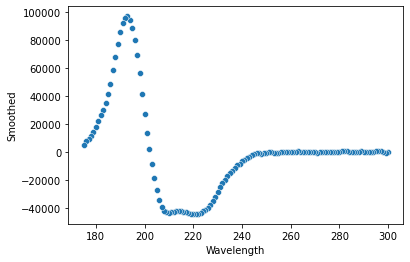

In [12]:
sns.scatterplot(data = dataDF, x = 'Wavelength', y = 'Smoothed')

<Axes: xlabel='Wavelength', ylabel='Final'>

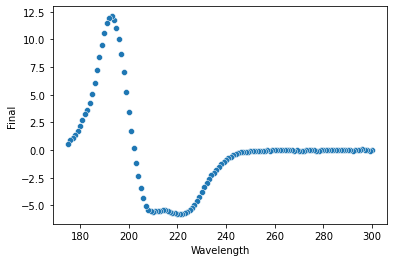

In [13]:
sns.scatterplot(data = dataDF, x = 'Wavelength', y = 'Final')

<Axes: xlabel='Wavelength', ylabel='Avg. Sample'>

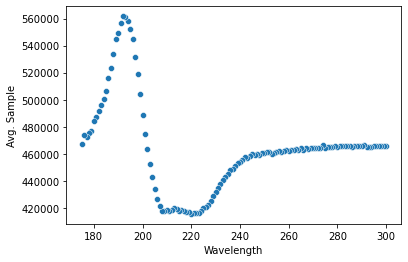

In [14]:
sns.scatterplot(data = dataDF, x = 'Wavelength', y = 'Avg. Sample')

The shape of all the plots look basically the same (and like CD spectra). So yay! Probably can use all of them for the model, but can try multiples to see how they turn out. Default to Smoothed if no apparent reason to choose one column over another.

## Let's put it all together! 

Note to self: don't forget to spot check some files throughout the process to make sure they all processed correctly. Assert statements will be our friend.

In [15]:
def process_pcd_file(zipfile, name):
    '''Function to process file in PCDBB's pcd format. Takes as inputs a ZipFile object of database and the name of the file.
    Outputs a dataframe that, for each file, contains a dictionary of the metadata, a dataframe of the CD data, and a dataframe
    of the calibration data.'''

    # Delimiter and column name definition
    dataDelim = 'DATA (1. Wavelength. 2. Final. 3. HT. 4.Smoothed. 5. Avg. Sample. 6. Avg. Baseline.)'
    calibDelim = 'CALIBRATION (1. Wavelength. 2. Calibration Spectrum.)'
    data_columns = 'Wavelength  Final  HT  Smoothed  Avg. Sample  Avg.Baseline'
    calib_columns = 'Wavelength  Calibration Spectrum'

    file = zipfile.read(name)
    
    #partitions into meta data, CD data, and calibration data
    file_splitmeta = file.partition(str.encode(dataDelim))
    file_splitdata = file_splitmeta[2].partition(str.encode(calibDelim))

    # put the meta data into a dictionary
    metastr = file_splitmeta[0].decode('utf8').replace('PCDDB DATA FILE', '')
    metalist = re.split(r"\s{2,}", metastr) # splits each entry into items in a list
    metalist = [entry for entry in metalist if entry != ''] # removes a few entries that are empty strings
    itm = iter(metalist)
    metadict = dict(zip(itm, itm))

    # DataFrame of CD data
    data = data_columns + file_splitdata[0].decode('utf8')
    dataDF = pd.read_csv(io.StringIO(data), sep = r'\s{2,}', engine = 'python')

    # DataFrame of calibration data
    calib = calib_columns + file_splitdata[2].decode('utf8')
    calibDF = pd.read_csv(io.StringIO(calib), sep = r'\s{2,}', engine = 'python')
    assert calibDF.loc[len(calibDF)-1, 'Wavelength'] == 'PCDDB-END'
    calibDF.drop(calibDF.tail(1).index, inplace = True)

    return metadict, dataDF, calibDF
    

The above is a function doing exactly what we did for our single test file for any .pcd file. (Note that it does not check whether the file format is correct, although it will likely throw an error if the input file deviates from the prescibed format. However, without having a better understanding of the distinctions with the other file types that might be mixed up with the .pcd files, it seems like all the checks that immediately came to mind could potentially cause more irritation than they prevented, so leaving as is for now.)

Next, I will create an empty DataFrame with the right shape and loop over the pcd list, adding the output from each file to said DataFrame.

In [16]:
df = pd.DataFrame(columns = ['Info', 'CD', 'Calibration'], index = pcdID)

for id in pcdID:
    name = id + '.pcd'
    meta, data, calib = process_pcd_file(z, name)
    df.at[id, 'Info'] = meta
    df.at[id, 'CD'] = data
    df.at[id, 'Calibration'] = calib

In [17]:
print(df)

                                                           Info  ...                                        Calibration
CD0000001000  {'PCDDBID': 'CD0000001000', 'FILE EXTRACTED': ...  ...      Wavelength  Calibration Spectrum
0        ...
CD0000002000  {'PCDDBID': 'CD0000002000', 'FILE EXTRACTED': ...  ...      Wavelength  Calibration Spectrum
0        ...
CD0000003000  {'PCDDBID': 'CD0000003000', 'FILE EXTRACTED': ...  ...      Wavelength  Calibration Spectrum
0        ...
CD0000004000  {'PCDDBID': 'CD0000004000', 'FILE EXTRACTED': ...  ...      Wavelength  Calibration Spectrum
0        ...
CD0000005000  {'PCDDBID': 'CD0000005000', 'FILE EXTRACTED': ...  ...      Wavelength  Calibration Spectrum
0        ...
...                                                         ...  ...                                                ...
CD0006158000  {'PCDDBID': 'CD0006158000', 'FILE EXTRACTED': ...  ...      Wavelength  Calibration Spectrum
0        ...
CD0006141000  {'PCDDBID': 'CD0006141000'

In [18]:
print(df['CD'])

CD0000001000         Wavelength     Final        HT   Smoothed...
CD0000002000         Wavelength     Final       HT  Smoothed  ...
CD0000003000         Wavelength     Final     HT  Smoothed  Av...
CD0000004000         Wavelength     Final     HT  Smoothed  Av...
CD0000005000         Wavelength     Final        HT   Smoothed...
                                      ...                        
CD0006158000         Wavelength     Final      HT  Smoothed  A...
CD0006141000        Wavelength               Final  ...       ...
CD0006187000        Wavelength                 Final  ...     ...
CD0006188000        Wavelength                Final  ...      ...
CD0006222000        Wavelength  Final        HT  Smoothed  Avg...
Name: CD, Length: 560, dtype: object


In [19]:
print(df.at['CD0006158000', 'CD'])

     Wavelength     Final      HT  Smoothed  Avg. Sample  Avg.Baseline
0           270 -0.006667  2.7427    2.7427       2.7427        2.7427
1           269 -0.006603  2.7445    2.7445       2.7445        2.7445
2           268 -0.020623  2.7461    2.7461       2.7461        2.7461
3           267 -0.009190  2.7476    2.7476       2.7476        2.7476
4           266  0.003143  2.7494    2.7494       2.7494        2.7494
..          ...       ...     ...       ...          ...           ...
96          174 -0.569470  6.1156    6.1156       6.1156        6.1156
97          173 -0.363880  6.7333    6.7333       6.7333        6.7333
98          172 -0.103060  6.8084    6.8084       6.8084        6.8084
99          171 -0.160420  6.8435    6.8435       6.8435        6.8435
100         170 -0.218550  6.8694    6.8694       6.8694        6.8694

[101 rows x 6 columns]


This looks like it populated exactly right! There is a lot of info here, so we will likely need to pull out subsets of this for the actual modeling, but this is now in a format where that should be relatively straightforward to do. Hooray! Now I will save the data for exploration and analysis.

In [20]:
df.to_pickle('pcd_df.pkl')